# Classificação de falhas em placas de aço

ALERTA ALERTA ALERTA <br>
QUEM SABE COLOCAR FOTINHA DE PLACA DE AÇO


INSERIR BREVE DESCRIÇÃO DO PROBLEMA <br>
http://archive.ics.uci.edu/dataset/198/steel+plates+faults

# 0. Setup

## 0.1 Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# scikit imports
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif

## 0.2 Definição dos diretórios

In [2]:
HOME_PATH = os.getcwd()
RAW_DATA_PATH = '/data/raw/'
INTERIM_DATA_PATH = '/data/interim/'

## 0.3 Carregamento dos dados

Vamos coletar os dados via Scikit-learn a partir do repositório de datasets da OpenML. <br>
<br>
Página do dataset na OpenML: https://www.openml.org/search?type=data&status=active&id=1504

In [3]:
steel_plate = fetch_openml(data_id=1504)  

steel_plate_raw = steel_plate.frame
steel_plate_raw.to_csv(HOME_PATH + RAW_DATA_PATH + 'steel_plate_raw.csv')

In [4]:
steel_plate_raw.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V25,V26,V27,V28,V29,V30,V31,V32,V33,Class
0,42,50,270900,270944,267,17,44,24220,76,108,...,0.8182,-0.2913,0.5822,1,0,0,0,0,0,1
1,645,651,2538079,2538108,108,10,30,11397,84,123,...,0.7931,-0.1756,0.2984,1,0,0,0,0,0,1
2,829,835,1553913,1553931,71,8,19,7972,99,125,...,0.6667,-0.1228,0.2150,1,0,0,0,0,0,1
3,853,860,369370,369415,176,13,45,18996,99,126,...,0.8444,-0.1568,0.5212,1,0,0,0,0,0,1
4,1289,1306,498078,498335,2409,60,260,246930,37,126,...,0.9338,-0.1992,1.0000,1,0,0,0,0,0,1


# 0.4 Funções auxiliares

In [46]:
def compute_anova_correlations(features_df, target_series):
    
    f_values, p_values = f_classif(features_df, target_series)
    
    
    anova_results = pd.DataFrame({
        'F_value': f_values,
        'p_value': p_values
    }, index=features_df.columns)
    
    
    anova_results = anova_results.sort_values(by="F_value", ascending=False)
    
    return anova_results

def select_most_relevant_features(X, y, threshold=0.2):
    # informação mútua
    mi_scores = mutual_info_classif(X, y)    
    
    mi_df = pd.DataFrame({
        'feature': X.columns,
        'mutual_info_score': mi_scores
    }).sort_values('mutual_info_score', ascending=False)    
    
    selected_features = mi_df[mi_df['mutual_info_score'] >= threshold]
    
    return mi_df, selected_features['feature'].tolist()

def plot_feature_importance(mi_df, selected_features, figsize=(10, 6), title="Feature Importance (Mutual Information)"):
    
    plt.figure(figsize=figsize)

    palette_tab10 = sns.color_palette("tab10", 10)   
    
    colors = ['orangered' if feature in selected_features else 'teal' for feature in mi_df['feature']]    
    
    plt.bar(mi_df['feature'], mi_df['mutual_info_score'], color=colors)    
    
    plt.xticks(rotation=45, ha='right')    
    
    plt.xlabel('Features')
    plt.ylabel('Mutual Information Score')
    plt.title(title)    
    
    plt.tight_layout()
    
    return plt

def advanced_feature_visualization(X, y, top_features):
    # cria um grid de subplots
    fig, axes = plt.subplots(
        nrows=len(top_features), 
        ncols=2,         
        figsize=(15, 4*len(top_features))
    )

    color_palette = 'flare'
    
    for i, feature in enumerate(top_features):
        
        sns.boxplot(
            x=y, 
            y=X[feature],
            hue=y, 
            ax=axes[i, 0],
            palette=color_palette,
            legend=False
        )
        axes[i, 0].set_title(f'Box Plot: {feature}')
        
        
        sns.violinplot(
            x=y, 
            y=X[feature],
            hue=y, 
            ax=axes[i, 1],
            palette=color_palette,
            legend=False
        )
        axes[i, 1].set_title(f'Violin Plot: {feature}')
    
    plt.tight_layout()
    plt.show()

# 1. Descrição dos dados

INSERIR BREVE DESCRIÇÃO DAS VARIÁVEIS: <br>
- VARIAVEIS INDEPENDENTES
- TARGETS

Como os nomes atuais das colunas não nos dizem muita coisa, vamos renomeá-las para facilitar nosso trabalho.

In [6]:
feature_names = [
    'X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas', 
    'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity', 'Minimum_of_Luminosity', 
    'Maximum_of_Luminosity', 'Length_of_Conveyer', 'TypeOfSteel_A300', 
    'TypeOfSteel_A400', 'Steel_Plate_Thickness', 'Edges_Index', 'Empty_Index', 
    'Square_Index', 'Outside_X_Index', 'Edges_X_Index', 'Edges_Y_Index', 
    'Outside_Global_Index', 'LogOfAreas', 'Log_X_Index', 'Log_Y_Index', 
    'Orientation_Index', 'Luminosity_Index', 'SigmoidOfAreas', 'Pastry', 
    'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults'
]

steel_plate_raw.columns = feature_names

In [7]:
steel_plate_raw

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,42,50,270900,270944,267,17,44,24220,76,108,...,0.8182,-0.2913,0.5822,1,0,0,0,0,0,1
1,645,651,2538079,2538108,108,10,30,11397,84,123,...,0.7931,-0.1756,0.2984,1,0,0,0,0,0,1
2,829,835,1553913,1553931,71,8,19,7972,99,125,...,0.6667,-0.1228,0.2150,1,0,0,0,0,0,1
3,853,860,369370,369415,176,13,45,18996,99,126,...,0.8444,-0.1568,0.5212,1,0,0,0,0,0,1
4,1289,1306,498078,498335,2409,60,260,246930,37,126,...,0.9338,-0.1992,1.0000,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,249,277,325780,325796,273,54,22,35033,119,141,...,-0.4286,0.0026,0.7254,0,0,0,0,0,0,2
1937,144,175,340581,340598,287,44,24,34599,112,133,...,-0.4516,-0.0582,0.8173,0,0,0,0,0,0,2
1938,145,174,386779,386794,292,40,22,37572,120,140,...,-0.4828,0.0052,0.7079,0,0,0,0,0,0,2
1939,137,170,422497,422528,419,97,47,52715,117,140,...,-0.0606,-0.0171,0.9919,0,0,0,0,0,0,2


## 1.1 Colunas, dtypes, forma e NaNs.

In [8]:
steel_plate_raw.shape

(1941, 34)

In [9]:
steel_plate_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1941 entries, 0 to 1940
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   X_Minimum              1941 non-null   int64   
 1   X_Maximum              1941 non-null   int64   
 2   Y_Minimum              1941 non-null   int64   
 3   Y_Maximum              1941 non-null   int64   
 4   Pixels_Areas           1941 non-null   int64   
 5   X_Perimeter            1941 non-null   int64   
 6   Y_Perimeter            1941 non-null   int64   
 7   Sum_of_Luminosity      1941 non-null   int64   
 8   Minimum_of_Luminosity  1941 non-null   int64   
 9   Maximum_of_Luminosity  1941 non-null   int64   
 10  Length_of_Conveyer     1941 non-null   int64   
 11  TypeOfSteel_A300       1941 non-null   int64   
 12  TypeOfSteel_A400       1941 non-null   int64   
 13  Steel_Plate_Thickness  1941 non-null   int64   
 14  Edges_Index            1941 non-null   f

Como podemos ver, não há nenhum dado faltante em nenhuma coluna. Também notamos que há somente variáveis numéricas em nosso conjunto de dados, a menos da variável 'Other_Faults'. <br> Faremos a transformação apropriada desta em um momento posterior.

## 1.2 Distribuição de classes (tipos de falha)

In [10]:
fault_types = ['Pastry','Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']

for fault in fault_types:

    if fault == 'Other_Faults':

        fault_df = steel_plate_raw.loc[steel_plate_raw['Other_Faults'] == '2']        
        fault_sample_size = fault_df.shape[0]

        print("Número de amostras para " + fault + " é de " + str(fault_sample_size))

    else:
        fault_df = steel_plate_raw.loc[steel_plate_raw[fault] == 1]
        fault_sample_size = fault_df.shape[0]

        print("Número de amostras para a falha " + fault + " é " + str(fault_sample_size))  

Número de amostras para a falha Pastry é 158
Número de amostras para a falha Z_Scratch é 190
Número de amostras para a falha K_Scatch é 391
Número de amostras para a falha Stains é 72
Número de amostras para a falha Dirtiness é 55
Número de amostras para a falha Bumps é 402
Número de amostras para Other_Faults é de 673


Notamos aqui um desbalanceamento na distribuição de falhas no conjunto todo. Isto será levado em conta na etapa seguinte.

# 2. Separação do conjunto de teste

In [11]:
steel_plate_interim = steel_plate_raw.copy()
steel_plate_interim.to_csv(HOME_PATH + INTERIM_DATA_PATH + 'steel_plate_interim.csv')

Antes de passarmos à nossa análise exploratória, vamos separar um subconjunto do nosso dataset para conjunto de teste. Como queremos evitar viés no modelo de classificação, faremos essa divisão de forma estratificada. <br>
Para isso, criaremos uma nova coluna para codificar os tipos de falha de maneira "ordinal" e não onehot. Vamos aproveitar também para fazer uma mudança na coluna 'Other_faults' a fim de colocá-la no mesmo formato das outras. 

In [12]:
steel_plate_interim['Other_Faults'] = steel_plate_interim['Other_Faults'].map({'1': 0, '2': 1}).astype('int64')
var_type = steel_plate_interim['Other_Faults'].dtype
new_values = steel_plate_interim['Other_Faults'].unique()

print('O novo tipo da coluna Other_Faults é: ' + str(var_type))
print('Com novos valores ' + str(new_values[0]) + ' e ' + str(new_values[1]))

O novo tipo da coluna Other_Faults é: int64
Com novos valores 0 e 1


In [13]:
steel_plate_interim['faults_ordinal'] = steel_plate_interim[fault_types].values.argmax(1) + 1

print('Conferindo as classes da nova coluna: ' + str(steel_plate_interim['faults_ordinal'].unique()))

Conferindo as classes da nova coluna: [1 2 3 4 5 6 7]


Feitas as transformações necessárias, passamos à divisão do dataset.

In [14]:
seed = 42

steel_plate_train_set, test_set = train_test_split(steel_plate_interim,
                                                   random_state= seed,
                                                   test_size=0.1,
                                                   stratify=steel_plate_interim['faults_ordinal'])

steel_plate_train_set.to_csv(HOME_PATH + INTERIM_DATA_PATH + 'steel_plate_train_set.csv')

In [15]:
for fault in test_set['faults_ordinal'].unique():
    n_amostras = test_set.loc[test_set['faults_ordinal'] == fault].shape[0]
    print("Número de amostras no conjunto de teste para a falha " + str(fault) + " é " + str(n_amostras))

Número de amostras no conjunto de teste para a falha 2 é 19
Número de amostras no conjunto de teste para a falha 3 é 39
Número de amostras no conjunto de teste para a falha 6 é 40
Número de amostras no conjunto de teste para a falha 7 é 68
Número de amostras no conjunto de teste para a falha 4 é 7
Número de amostras no conjunto de teste para a falha 5 é 6
Número de amostras no conjunto de teste para a falha 1 é 16


Como queríamos, temos uma amostra estratificada como teste.

# 3. Análise exploratória

Passaremos agora ao estudo do dataset, buscando informações como:

- distribuição das variáveis;
- possíveis correlações entre elas;
- padrões e insights que possam nos ajudar a selecionar os modelos.

## 3.1 Métricas descritivas

In [16]:
steel_plate_features = steel_plate_train_set.drop(fault_types + ['faults_ordinal'], axis=1)

steel_plate_features.describe()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
count,1746.000000,1746.000000,1.746000e+03,1.746000e+03,1746.000000,1746.000000,1746.000000,1.746000e+03,1746.000000,1746.000000,...,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000
mean,569.623711,615.522337,1.647658e+06,1.647713e+06,1870.022337,110.494273,83.121420,2.033785e+05,84.853952,130.071592,...,0.032657,0.611694,0.812659,0.571592,2.486809,1.334260,1.400993,0.080812,-0.131175,0.585683
std,521.576009,498.249719,1.797602e+06,1.797615e+06,5268.962842,309.030218,447.705639,5.165287e+05,31.938029,18.542015,...,0.055336,0.243656,0.233412,0.482977,0.785509,0.477792,0.454127,0.500984,0.148373,0.338409
min,0.000000,4.000000,6.712000e+03,6.724000e+03,2.000000,2.000000,1.000000,2.500000e+02,0.000000,37.000000,...,0.001500,0.014400,0.048400,0.000000,0.301000,0.301000,0.000000,-0.991000,-0.998900,0.119000
25%,51.000000,191.000000,4.664930e+05,4.665182e+05,84.000000,15.000000,13.000000,9.474750e+03,64.000000,124.000000,...,0.006600,0.409100,0.594825,0.000000,1.924300,1.000000,1.079200,-0.333300,-0.195575,0.248200
50%,430.500000,463.500000,1.173774e+06,1.173882e+06,172.500000,26.000000,25.000000,1.920750e+04,90.000000,127.000000,...,0.010200,0.638800,0.946900,1.000000,2.236750,1.176100,1.322200,0.090900,-0.133050,0.509600
75%,1057.000000,1075.750000,2.173212e+06,2.173224e+06,789.500000,83.000000,83.000000,8.033400e+04,107.000000,140.000000,...,0.022800,0.800000,1.000000,1.000000,2.897325,1.515150,1.732400,0.500000,-0.066275,0.999800
max,1705.000000,1713.000000,1.298766e+07,1.298769e+07,152655.000000,10449.000000,18152.000000,1.159141e+07,196.000000,253.000000,...,0.622600,1.000000,1.000000,1.000000,5.183700,2.938500,4.258700,0.991700,0.591700,1.000000


## 3.2 Análise de correlações

Dado o grande número de features em nosso dataset, a análise dos dados via visualizações, sobre todas as variáveis, fica inviável. Por exemplo, se fôssemos plotar todos os gráficos de dispersão bivariados, teríamos 28²/2 plots a analisar (só para as features). Sendo assim, começaremos por uma análise de correlação entre variáveis, a fim de potencialmente selecionarmos as features mais relevantes para nosso problema, e então passar para uma análise mais detalhada sobre tais.

Vamos primeiro plotar uma matriz de correlações entre as features.

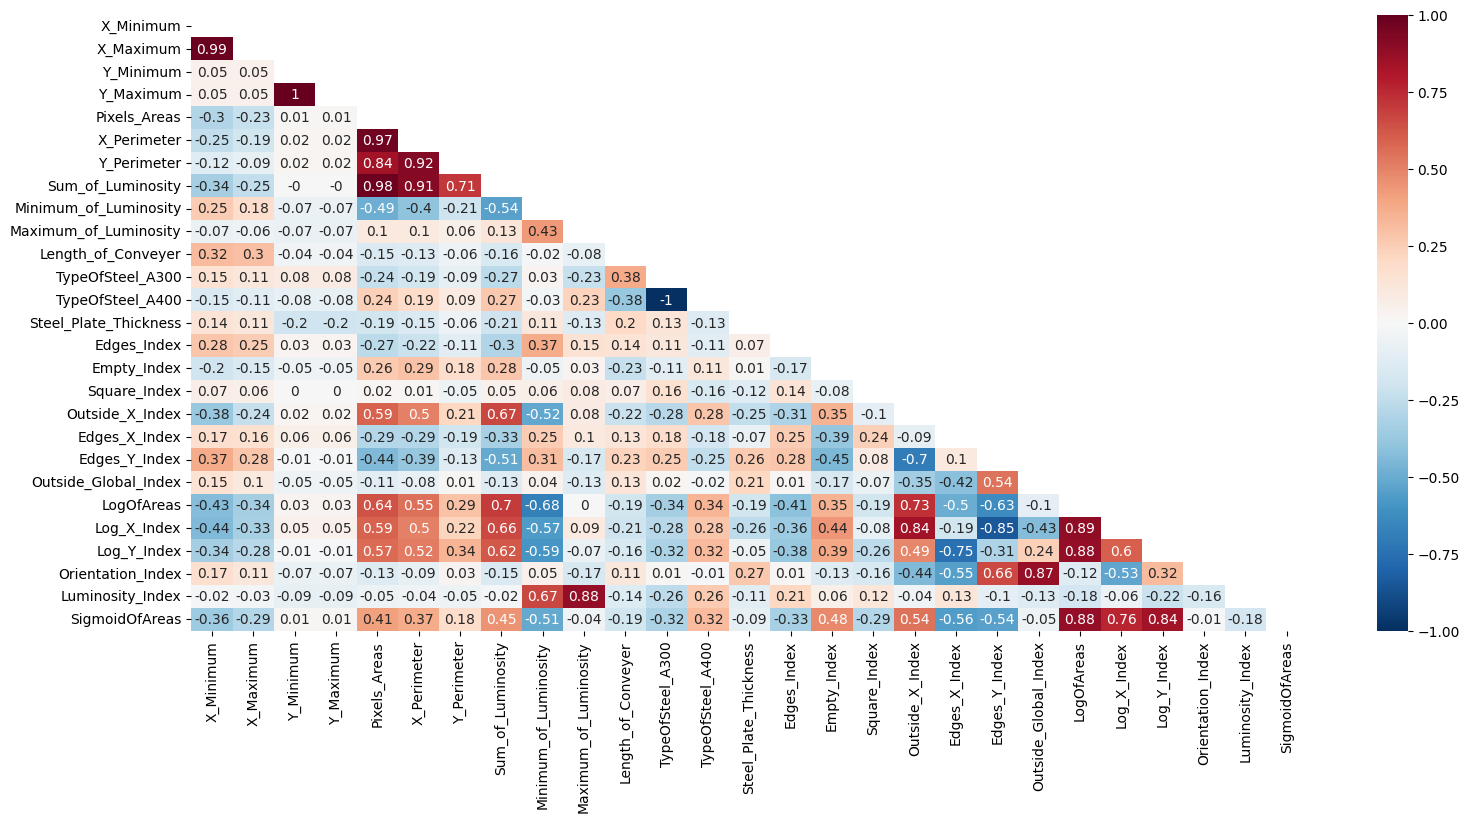

In [17]:
corr_matrix = steel_plate_features.corr()
corr_matrix = round(corr_matrix, 2)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

fig, ax = plt.subplots(1, 1, figsize=(18, 8))
sns.heatmap(corr_matrix,
            vmin=-1,
            vmax=1,
            cmap='RdBu_r',
            annot=True,
            ax=ax,
            mask=mask)
plt.show()

Note a forte correlação entre algumas de nossas features, por exemplo, X_Maximum e X_Minimum. Isto pode ser um indicativo de que não precisamos manter as duas para o treino do modelo. Seguiremos com mais alguns testes.


Abaixo, vamos realizar o teste de Informação Mútua. Em poucas palavras, este teste mede o quanto de informação podemos inferir sobre uma variável aleatória X observando uma outra variável aleatória Y. No nosso contexto, vamos performar o teste entre a variável alvo e as diferentes features. Além disso, nossa função retorna uma lista de features com score de MI acima de um dado limiar (default=0.2).

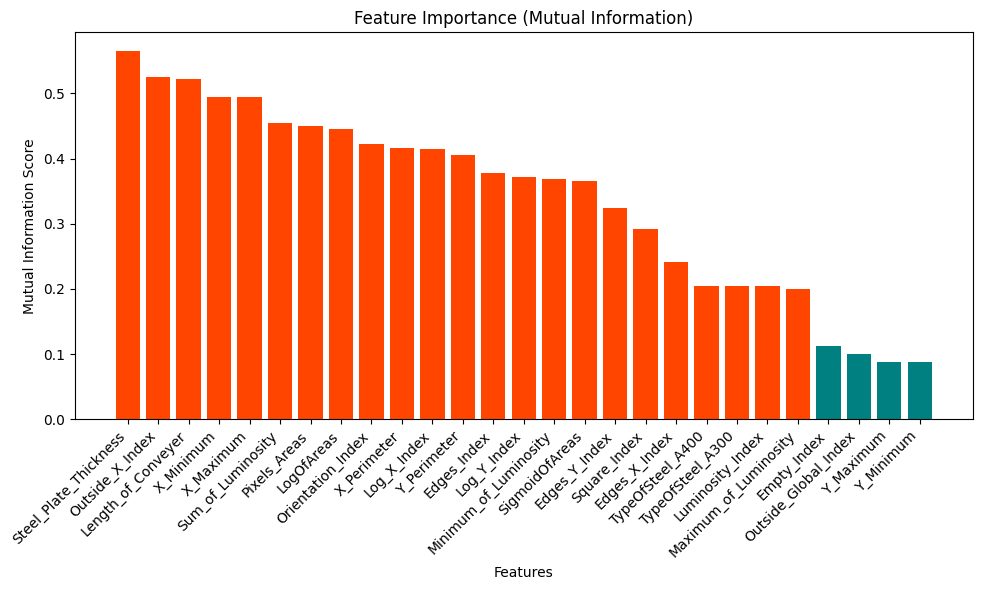

In [18]:
mi_threshold = 0.2

mutual_info_df, mutual_info_list = select_most_relevant_features(steel_plate_features, steel_plate_train_set['faults_ordinal'], threshold=mi_threshold)

plot = plot_feature_importance(mutual_info_df, mutual_info_list)
plot.show()

## 3.3 Visualizações univariadas

Abaixo, plotamos gráficos de caixa e violino para os n top features da lista retornada acima.

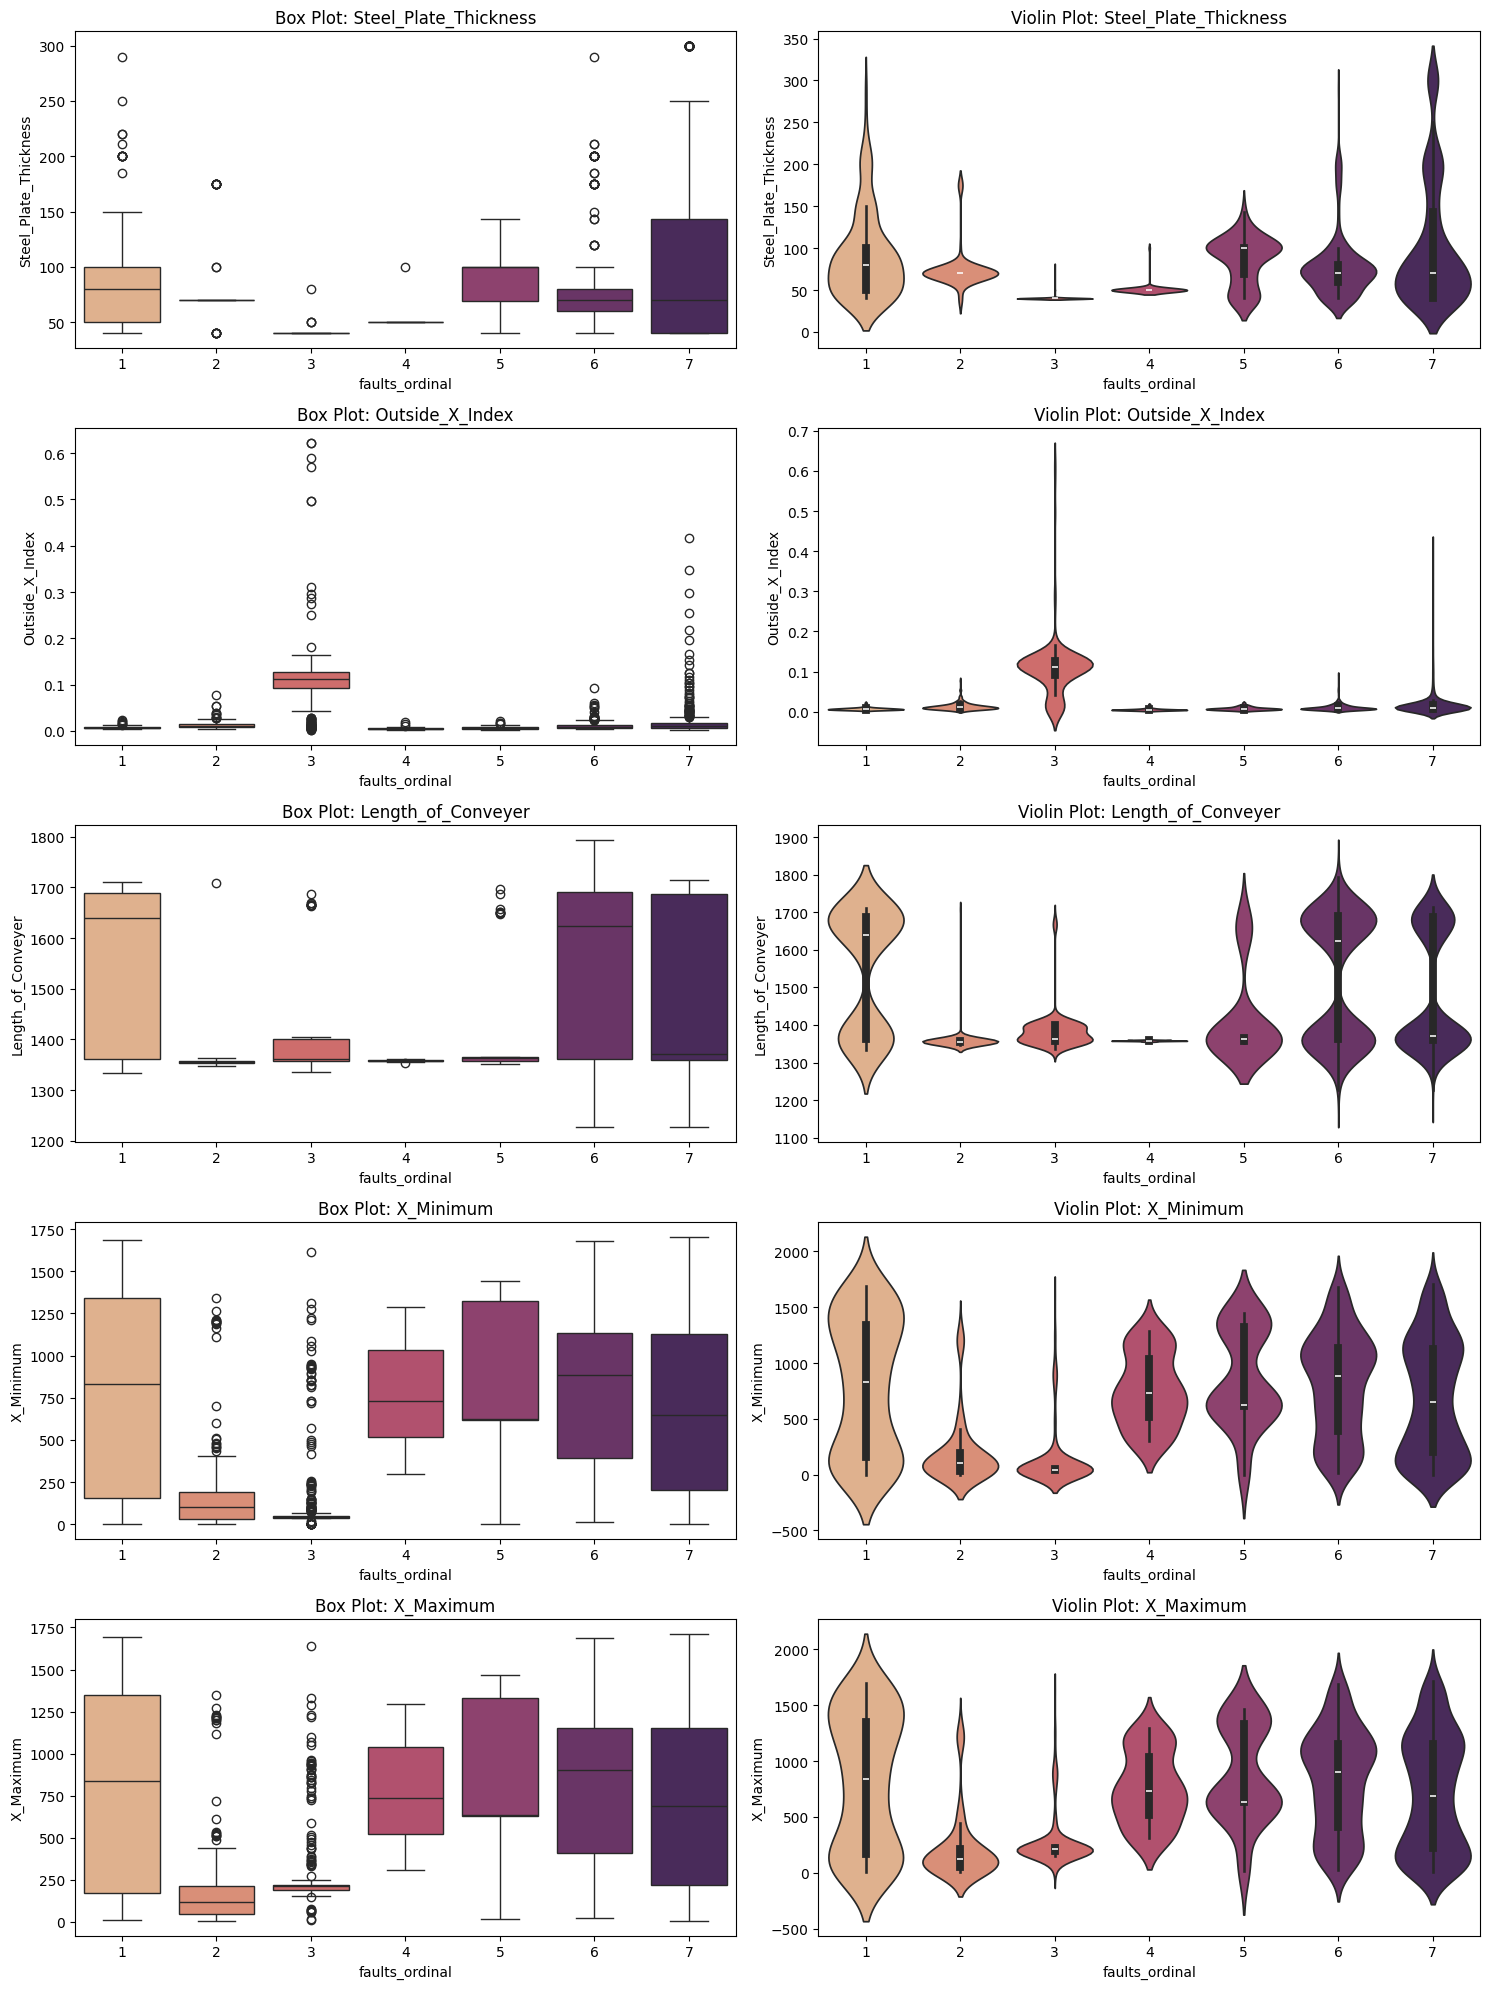

In [47]:
top_n_features = 5

advanced_feature_visualization(steel_plate_features, steel_plate_train_set['faults_ordinal'], mutual_info_list[0:top_n_features])

Como indicado pelo teste, vemos que há uma mudança significativa na distribuição destas variáveis entre as 7 diferentes classes. Isto nos sugere que tais variáveis são bons preditores (features) para nossos modelos.

COLOCAR ALGUNS GRÁFICOS BIVARIADOS CRUZANDO FEATURES (SCATTERPLOTS)

<Axes: xlabel='Pixels_Areas', ylabel='SigmoidOfAreas'>

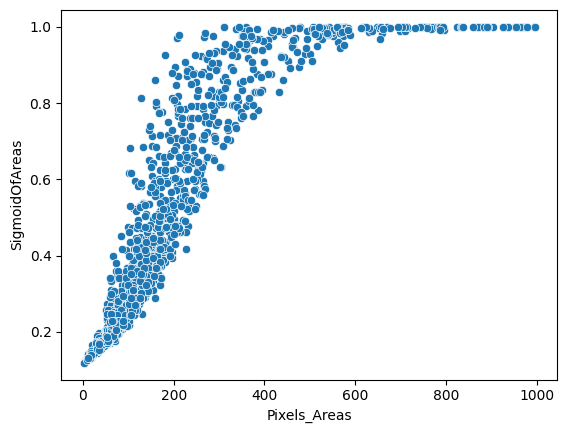

In [55]:
sns.scatterplot(data=steel_plate_features.loc[steel_plate_features['Pixels_Areas'] <1000], x='Pixels_Areas', y='SigmoidOfAreas')

<Axes: xlabel='Pixels_Areas', ylabel='LogOfAreas'>

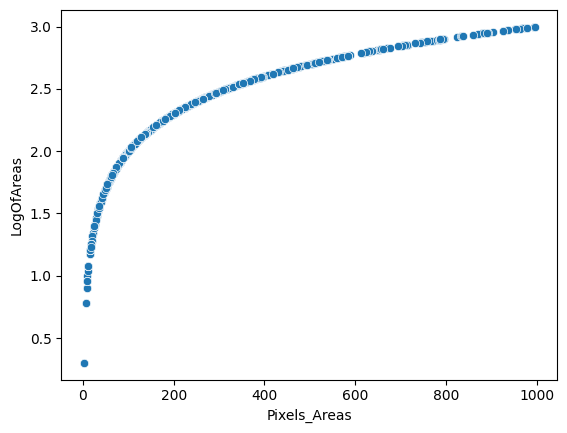

In [56]:
sns.scatterplot(data=steel_plate_features.loc[steel_plate_features['Pixels_Areas'] <1000], x='Pixels_Areas', y='LogOfAreas')

# 4. Modelos

COMENTAR SELEÇÃO DE FEATURES:
- TIRAR UM DOS TIPOS DE AÇO pois sao mutuamente excludentes

RASCUNHOS E TESTES

MODELOS A SEREM TESTADOS:

- regressão logística
- cart
- random forest
- naive bayes
- svm (diferentes regimes)